# CEO Time Use and Firm Performance: A Topic Model Application

This notebook estimates models for the association between CEO time allocation and firm performance, reproducing results from Table 2 of [Battaglia, Christensen, Hansen & Sacher (2024)](https://arxiv.org/abs/2402.15585). The analysis demonstrates bias correction methods for ML-generated regressors in the context of topic modeling.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import your regression functions
from ValidMLInference import (
    ols, ols_bca_topic, load_topic_model_data
)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## The dataset

The role of CEOs in shaping firm performance is important for many academic and policy debates, but until recently little data existed on what CEOs do with their time. To fill this void, Bandiera et al. (2020) collects diary data on a set of CEO activities from a sample of manufacturing firms. The paper describes salient differences in executive time use and relates these differences to firm and CEO characteristics and firm outcomes.
The survey consists of five questions with categorical responses:

 - (Q1) the type of activity (meeting, public event, etc.)
 - (Q2) duration of activity (15m, 30m, etc.)
 - (Q3) whether the activity is planned or unplanned
 - (Q4) the number of participants in the activity
 - (Q5) the function of the participants in the activity (HR, finance, suppliers, etc.)

Survey responses are recorded for each 15-minute interval of a given week, e.g. Monday 8am-8:15am, Monday 8:15am-8:30am, and so forth. The sample consists of V = 654 answer combinations observed across the five questions.

The data are modeled as a topic model, with K = 2 topics. The estimated $\hat{\beta}_1$ places relatively higher mass on features associated with "management," like communicating with other C-suite executives and holding large, multi-function meetings, or suppliers, while $\hat{\beta}_2$ places relatively higher mass on features associated with "leadership" - like communicating with other C-suite executives and holding large, multi-function meetings.

In [19]:
topic_data = load_topic_model_data()

Z = topic_data['covars']                    # Control variables
estimation_data = topic_data['estimation_data']  # Main dataset
gamma_draws = topic_data['gamma_draws']     # MCMC draws
theta_est_full = topic_data['theta_est_full']   # Full sample topic estimates
theta_est_samp = topic_data['theta_est_samp']   # Subsample topic estimates
beta_est_full = topic_data['beta_est_full']     # Full sample topic-word distributions
beta_est_samp = topic_data['beta_est_samp']     # Subsample topic-word distributions
lda_data = topic_data['lda_data']          # LDA validation data

# Dependent variable: log employment, country fixed effects, and survey-wave fixed effects
Y = estimation_data['ly']
sigma_y = np.std(Y)

print(f"Sample size: {len(Y)}")
print(f"Number of control variables: {Z.shape[1]}")
print(f"Standard deviation of Y: {sigma_y:.3f}")

# Show sample of the data
sample_data = pd.DataFrame({
    'Y': Y,
    'theta_topic1': theta_est_full[:, 0],
    'control1': Z[:, 0],
    'control2': Z[:, 1]
})

print("\nSample data:")
print(sample_data.head())

Sample size: 916
Number of control variables: 11
Standard deviation of Y: 1.544

Sample data:
           Y  theta_topic1  control1  control2
0  12.352137      0.605186  1.268126       0.0
1  10.096356      0.084489  1.113297       0.0
2  14.075560      0.969039  3.227946       0.0
3  12.358381      0.288178  1.672314       0.0
4  10.530302      0.430811  0.728468       0.0


## Estimation strategy

The paper's use of the two-step strategy may, however, lead to invalid inference. To explore this possibility, we first replicate the authors' two-step strategy, estimating $\hat{\theta}_i$ by LDA, then regressing the log value of each CEO's firm on $\hat{\theta}_i$ and controls including log employment, country fixed effects, and survey-wave fixed effects.

## Two-step strategy

The two-step approach now estimates a smaller insignificant effect, while both bias correction and joint estimation continue to estimate a significant effect.

In [20]:
# Full sample two-step estimation
theta_full = theta_est_full
Xhat_full = np.column_stack([theta_full[:, 0], Z])  # First topic + controls

# Create variable names
var_names = ['topic1'] + [f'control_{i+1}' for i in range(Z.shape[1])]

lm_full = ols(Y=Y, X=Xhat_full, se=True, intercept=True, names=var_names)

print("Full Sample Two-Step Estimation:")
print(lm_full.summary())

Full Sample Two-Step Estimation:
            Estimate  Std. Error    z value     P>|z|      2.5%      97.5%
Intercept   9.874123    0.159194  62.025623  0.000000  9.562108  10.186138
topic1      0.404658    0.092081   4.394608  0.000011  0.224184   0.585133
control_1   1.211107    0.028622  42.314381  0.000000  1.155010   1.267205
control_2  -0.042806    0.392070  -0.109179  0.913060 -0.811248   0.725636
control_3   0.276743    0.198298   1.395590  0.162838 -0.111914   0.665400
control_4   0.560206    0.191961   2.918327  0.003519  0.183969   0.936443
control_5   0.591815    0.176113   3.360416  0.000778  0.246639   0.936991
control_6   0.336933    0.163165   2.064980  0.038925  0.017135   0.656731
control_7   0.762824    0.090040   8.472091  0.000000  0.586350   0.939299
control_8   0.828211    0.078965  10.488370  0.000000  0.673443   0.982979
control_9   0.680610    0.082034   8.296700  0.000000  0.519827   0.841394
control_10 -0.340563    0.126065  -2.701483  0.006903 -0.587646  -0

In [21]:
# 10% Subsample two-step estimation
theta_samp = theta_est_samp
Xhat_samp = np.column_stack([theta_samp[:, 0], Z])

lm_samp = ols(Y=Y, X=Xhat_samp, se=True, intercept=True, names=var_names)

print("10% Subsample Two-Step Estimation:")
print(lm_samp.summary())

10% Subsample Two-Step Estimation:
            Estimate  Std. Error    z value     P>|z|      2.5%      97.5%
Intercept   9.940524    0.170793  58.202244  0.000000  9.605776  10.275272
topic1      0.226714    0.135119   1.677886  0.093369 -0.038114   0.491541
control_1   1.237230    0.028316  43.694130  0.000000  1.181732   1.292728
control_2  -0.062827    0.397736  -0.157962  0.874487 -0.842376   0.716721
control_3   0.260756    0.199772   1.305268  0.191802 -0.130790   0.652301
control_4   0.530769    0.193807   2.738644  0.006169  0.150914   0.910624
control_5   0.571770    0.177352   3.223932  0.001264  0.224167   0.919373
control_6   0.322330    0.163247   1.974497  0.048325  0.002372   0.642287
control_7   0.808265    0.091661   8.817999  0.000000  0.628613   0.987917
control_8   0.890245    0.079231  11.236112  0.000000  0.734956   1.045534
control_9   0.697467    0.083427   8.360213  0.000000  0.533953   0.860981
control_10 -0.362645    0.128799  -2.815599  0.004869 -0.615086  

## Bias correction

The empirical analogue of this expression is $\hat{\theta}_i$ for the simple model. While not directly applicable here as the topic model structure is more complex, it still allows one to qualitatively compare sampling error (reflected by $\hat{\zeta}^{-1}_j$) and measurement error (reflected by $\hat{\epsilon}[\hat{\zeta}^{-1}_j]$). The empirical analogue of this expression is 0.44.

In [22]:
# Full sample bias correction
kappa_full = np.mean(1.0 / lda_data[:, 0]) * np.sqrt(len(lda_data))
S = np.array([[1.0, 0.0]])  # Topic loadings: first topic active

print(f"Kappa (full): {kappa_full:.3f}")

bc_full = ols_bca_topic(
    Y=Y,
    Q=Z,                    # Control variables
    W=theta_est_full,       # Document-topic proportions
    S=S,                    # Topic loadings
    B=beta_est_full,        # Topic-word distributions
    k=kappa_full,           # Scaling parameter
    intercept=True
)

print("Full Sample Bias Correction:")
print(bc_full.summary())

Kappa (full): 0.442
Full Sample Bias Correction:
           Estimate  Std. Error    z value         P>|z|      2.5%      97.5%
Intercept  9.842479    0.159194  61.826851  0.000000e+00  9.530464  10.154494
topic_1    0.474253    0.092081   5.150410  2.599174e-07  0.293778   0.654728
Q_1        1.204900    0.028622  42.097511  0.000000e+00  1.148803   1.260998
Q_2       -0.032197    0.392070  -0.082121  9.345505e-01 -0.800639   0.736245
Q_3        0.284560    0.198298   1.435010  1.512844e-01 -0.104097   0.673217
Q_4        0.569446    0.191961   2.966466  3.012437e-03  0.193209   0.945683
Q_5        0.598246    0.176113   3.396936  6.814498e-04  0.253070   0.943422
Q_6        0.341925    0.163165   2.095576  3.611979e-02  0.022127   0.661724
Q_7        0.750862    0.090040   8.339242  0.000000e+00  0.574388   0.927337
Q_8        0.813897    0.078965  10.307093  0.000000e+00  0.659129   0.968665
Q_9        0.674966    0.082034   8.227897  2.220446e-16  0.514183   0.835750
Q_10      -0.33

In [23]:
# 10% Subsample bias correction
kappa_samp = np.mean(1.0 / lda_data[:, 1]) * np.sqrt(len(lda_data))

print(f"Kappa (subsample): {kappa_samp:.3f}")

bc_samp = ols_bca_topic(
    Y=Y,
    Q=Z,
    W=theta_est_samp,
    S=S,
    B=beta_est_samp,
    k=kappa_samp,
    intercept=True
)

print("10% Subsample Bias Correction:")
print(bc_samp.summary())

Kappa (subsample): 4.262
10% Subsample Bias Correction:
           Estimate  Std. Error    z value         P>|z|      2.5%     97.5%
Intercept  9.511539    0.170793  55.690510  0.000000e+00  9.176791  9.846286
topic_1    1.053774    0.135119   7.798883  6.217249e-15  0.788946  1.318602
Q_1        1.200861    0.028316  42.409702  0.000000e+00  1.145363  1.256358
Q_2        0.089161    0.397736   0.224172  8.226236e-01 -0.690388  0.868710
Q_3        0.368240    0.199772   1.843303  6.528472e-02 -0.023305  0.759785
Q_4        0.619395    0.193807   3.195934  1.393788e-03  0.239540  0.999250
Q_5        0.635071    0.177352   3.580852  3.424756e-04  0.287467  0.982674
Q_6        0.374949    0.163247   2.296825  2.162873e-02  0.054991  0.694906
Q_7        0.720312    0.091661   7.858446  3.996803e-15  0.540660  0.899964
Q_8        0.812913    0.079231  10.260080  0.000000e+00  0.657624  0.968203
Q_9        0.639239    0.083427   7.662267  1.820766e-14  0.475726  0.802753
Q_10      -0.407946 

## Joint Estimation

In other words, there are a relatively large number of survey responses per CEO compared to the number of surveyed CEOs, meaning the measurement error in $\hat{\theta}_i$ is small relative to sampling error. To increase measurement error, we take a random 10% subsample of survey responses for each CEO, which can be thought of as observing half a day of behavior rather than a five-day workweek.

In [24]:
# Joint estimation using MCMC draws (scaled by dependent variable standard deviation)
gamma_scaled = gamma_draws * sigma_y
gamma_hat_1 = np.mean(gamma_scaled, axis=0)

# Calculate empirical confidence intervals from MCMC draws
alpha = 0.05
ci_lower_1 = np.percentile(gamma_scaled, 100 * alpha/2, axis=0)
ci_upper_1 = np.percentile(gamma_scaled, 100 * (1 - alpha/2), axis=0)

print("Joint estimation results:")
print(f"Topic 1 coefficient: {gamma_hat_1[0]:.3f} [{ci_lower_1[0]:.3f}, {ci_upper_1[0]:.3f}]")
print(f"Topic 2 coefficient: {gamma_hat_1[1]:.3f} [{ci_lower_1[1]:.3f}, {ci_upper_1[1]:.3f}]")

Joint estimation results:
Topic 1 coefficient: 0.402 [0.240, 0.602]
Topic 2 coefficient: 0.439 [0.153, 0.711]


## Comparison of methods

What's more, neither bias correction nor joint estimation shifts the estimated coefficient upward by a large amount. This shows that bias is not an inevitable part of using AI/ML-generated variables, but rather depends on the empirical setting.

In [25]:
# Extract key coefficients for the first topic (management)
results_data = []

# Helper function to get confidence intervals from regression results
def get_ci(result, coef_idx=0, alpha=0.05):
    coef = result.coef[coef_idx]
    se = np.sqrt(result.vcov[coef_idx, coef_idx])
    z_crit = stats.norm.ppf(1 - alpha/2)
    return coef - z_crit * se, coef + z_crit * se

# Two-step results
ci_full_lower, ci_full_upper = get_ci(lm_full, 1)  # topic1 is index 1 (after intercept)
ci_samp_lower, ci_samp_upper = get_ci(lm_samp, 1)

# Bias correction results
ci_bc_full_lower, ci_bc_full_upper = get_ci(bc_full, 1)  # topic_1 is index 1
ci_bc_samp_lower, ci_bc_samp_upper = get_ci(bc_samp, 1)

results_data = [
    {"Sample": "Full", "Method": "Two-Step", 
     "Estimate": lm_full.coef[1], "CI_Lower": ci_full_lower, "CI_Upper": ci_full_upper},
    {"Sample": "10% Subsample", "Method": "Two-Step", 
     "Estimate": lm_samp.coef[1], "CI_Lower": ci_samp_lower, "CI_Upper": ci_samp_upper},
    {"Sample": "Full", "Method": "Bias Correction", 
     "Estimate": bc_full.coef[1], "CI_Lower": ci_bc_full_lower, "CI_Upper": ci_bc_full_upper},
    {"Sample": "10% Subsample", "Method": "Bias Correction", 
     "Estimate": bc_samp.coef[1], "CI_Lower": ci_bc_samp_lower, "CI_Upper": ci_bc_samp_upper},
    {"Sample": "Full", "Method": "Joint", 
     "Estimate": gamma_hat_1[0], "CI_Lower": ci_lower_1[0], "CI_Upper": ci_upper_1[0]}
]

results_df = pd.DataFrame(results_data)
results_df = results_df.round(3)

print("Comparison of Methods:")
print(results_df.to_string(index=False))

Comparison of Methods:
       Sample          Method   Estimate     CI_Lower   CI_Upper
         Full        Two-Step  0.4046584   0.22418365  0.5851332
10% Subsample        Two-Step 0.22671358 -0.038113967 0.49154115
         Full Bias Correction 0.47425315    0.2937784 0.65472794
10% Subsample Bias Correction   1.053774   0.78894645  1.3186016
         Full           Joint   0.401849     0.239983   0.602348


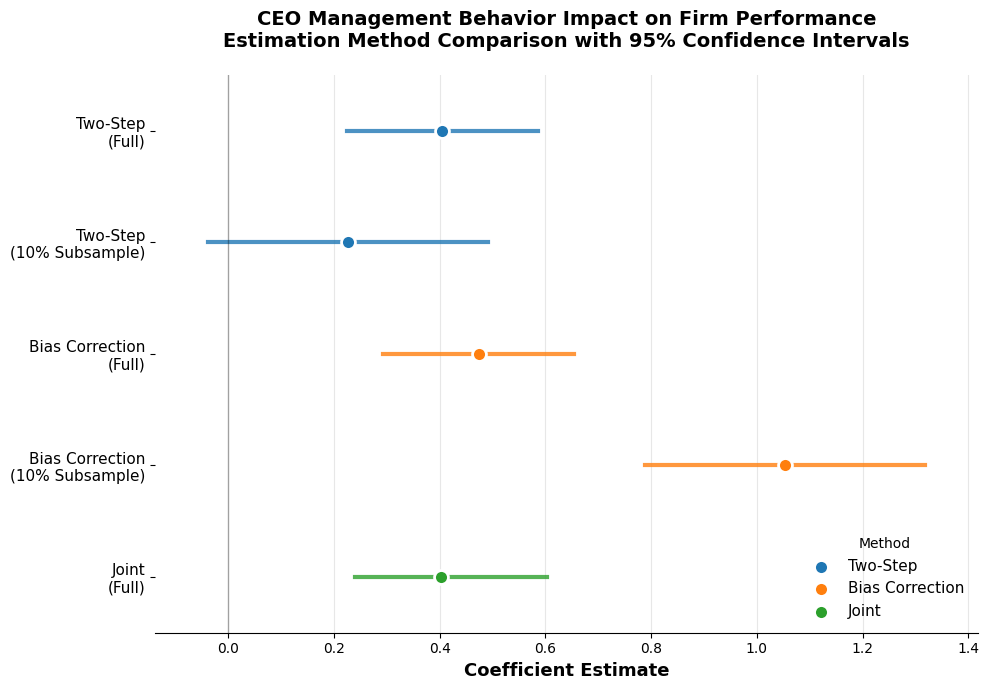

In [26]:
plt.style.use('default')  
fig, ax = plt.subplots(figsize=(10, 7))
plot_data = results_df.copy()
plot_data['Method_Sample'] = plot_data['Method'] + '\n(' + plot_data['Sample'] + ')'

colors = {
    'Two-Step': '#1f77b4',       
    'Bias Correction': '#ff7f0e',  
    'Joint': '#2ca02c'            
}

y_positions = np.arange(len(plot_data))[::-1]  

for i, (idx, row) in enumerate(plot_data.iterrows()):
    y_pos = y_positions[i]
    method = row['Method']
    color = colors[method]
    
    ax.plot([row['CI_Lower'], row['CI_Upper']], [y_pos, y_pos], 
            color=color, linewidth=3, alpha=0.8)

    ax.scatter(row['Estimate'], y_pos, color=color, s=100, 
               edgecolors='white', linewidth=2, zorder=10,
               label=method if i == 0 or method != plot_data.iloc[i-1]['Method'] else "")

ax.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

ax.set_yticks(y_positions)
ax.set_yticklabels(plot_data['Method_Sample'], fontsize=11)
ax.set_xlabel('Coefficient Estimate', fontsize=13, fontweight='600')
ax.set_title('CEO Management Behavior Impact on Firm Performance\nEstimation Method Comparison with 95% Confidence Intervals', 
             fontsize=14, fontweight='700', pad=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

ax.legend(unique_handles, unique_labels, title='Method', 
          frameon=False, loc='lower right', fontsize=11)

x_margin = 0.1
x_min = min(plot_data['CI_Lower']) - x_margin
x_max = max(plot_data['CI_Upper']) + x_margin
ax.set_xlim(x_min, x_max)

ax.set_ylim(-0.5, len(plot_data) - 0.5)

plt.tight_layout()
plt.show()



In [27]:
print("\nSummary of Results:")
print("=" * 60)
summary_table = plot_data[['Method', 'Sample', 'Estimate', 'CI_Lower', 'CI_Upper']].copy()
summary_table['95% CI'] = summary_table.apply(
    lambda row: f"[{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}]", axis=1
)
display_table = summary_table[['Method', 'Sample', 'Estimate', '95% CI']]

display_table = display_table.copy()
display_table['Estimate'] = display_table['Estimate'].apply(lambda x: f"{x:.3f}")

print(display_table.to_string(index=False))


Summary of Results:
         Method        Sample Estimate          95% CI
       Two-Step          Full    0.405  [0.224, 0.585]
       Two-Step 10% Subsample    0.227 [-0.038, 0.492]
Bias Correction          Full    0.474  [0.294, 0.655]
Bias Correction 10% Subsample    1.054  [0.789, 1.319]
          Joint          Full    0.402  [0.240, 0.602]
